In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas_datareader import data
import scipy.optimize as sco
from datetime import date

In [58]:
csvFile = pd.read_csv("Tickers.csv")
# drop RUB denominated as unable to programatically find FX rate
csvFile = csvFile[csvFile.Currency!="RUB"]
csvFile.reset_index(drop=True, inplace=True)

In [ ]:
# FX translation
usdAUD = data.DataReader("DEXUSAL","fred") # convention USD/AUD
usdEUR = data.DataReader("DEXUSEU","fred") # convention EUR/USD
usdCHF = data.DataReader("DEXSZUS","fred") # convention CHF/USD
usdDKK = data.DataReader("DEXDNUS","fred") # convention DKK/USD
usdJPY = data.DataReader("DEXJPUS","fred") # convention JPY/USD
usdHKD = data.DataReader("DEXHKUS","fred") # convention HKD/USD
usdBRL = data.DataReader("DEXBZUS","fred") # convention BRL/USD

Currently the script is designed to only work a single market at a time. Specifically it drops all non-US stocks from the investment universe defined in the variable "csvFile".

Next steps: incorporate FX translations and date adjustments (differing holidays mean different markets are closed at different times for example) between the different markets so that it can handle a global investment universe

In [59]:
# divide tickers by geography
usTicker = []
for i in csvFile.index:
    if csvFile.Currency.iloc[i] == "USD":
        usTicker.append(csvFile.Ticker.iloc[i])

In [60]:
start = date(2000,1,1)
end = date(2020,10,16)
usTickersData = data.DataReader(usTicker,start=start, end = end, data_source="yahoo")["Adj Close"]
#usTickersData = usTickersData.dropna(axis='rows')
returns = usTickersData.pct_change()
expected_returns = returns.mean()
cov_matrix = returns.cov()

In [69]:
def portfolio_performance(weights, expected_returns, cov_matrix):
    """
    Returns the portfolio's expected return and standard deviation
    
    expected returns and cov_matrix variables are expected to be daily values
    """

    pf_return = np.sum(weights*expected_returns)*252
    pf_std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))*np.sqrt(252)
    return pf_return, pf_std

def negative_sharpe(weights, expected_returns, cov_matrix, risk_free):
    '''
    Calculates the negative Sharpe ratio
    args:
    weights -- portfolio weights
    expected_ returns -- mean returns
    cov_matrix -- covariance matrix
    risk_free -- risk free rate
    '''
    pf_return, pf_std = portfolio_performance(weights, expected_returns, cov_matrix)
    neg_sharpe = - (pf_return - risk_free)/pf_std
    return neg_sharpe

def portfolio_vol(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

def max_sharpe_ratio(expected_returns, cov_matrix, risk_free):
    """
    Calculates the maximimum sharpe ratio portfolio by formulating an optimization problem.
    """
    size_portfolio = expected_returns.count()
    bounds = tuple((0, 1) for x in range(size_portfolio))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix, risk_free) #args to be passed to optimising function
    results = sco.minimize(negative_sharpe, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

def min_var(expected_returns, cov_matrix):
    """
    Calculates the minimum variance portfolio by formulating an optimization problem.
    """
    size_portfolio = expected_returns.count()
    bounds = tuple((0, 1) for x in range(size_portfolio))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) -1})
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix) #args to be passed to optimising function
    results = sco.minimize(portfolio_vol, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

def portfolio_return(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[0]

def eff_return(expected_returns, cov_matrix, target_return):
    '''
    Calculate the optimal portfolio construction for target_return
    '''
    
    size_portfolio = expected_returns.count()
    constraints = ({'type':'eq','fun': lambda x:portfolio_return(x, expected_returns, cov_matrix)-target_return},
                   {'type':'eq', 'fun': lambda x:np.sum(x)-1})
    bounds = tuple((0, 1) for x in range(size_portfolio))
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix) #args to be passed to optimising function
    results = sco.minimize(portfolio_vol, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

def eff_frontier(expected_returns, cov_matrix, target_range):
    '''
    
    args:
    expected_returns -- 
    cov_matrix -- 
    target_range -- list of returns to plot
    
    '''
    graph = []
    for target in target_range:
        graph.append(eff_return(expected_returns, cov_matrix, target))
    return graph

def mvo(expected_returns, cov_matrix):
    '''
    Construction of the efficient frontier by applying a linear combination of the Max Sharpe and Min Var portfolios
    This function does not allow short-selling in its estimation.
    
    '''
    
    max_sharpe = max_sharpe_ratio(expected_returns, cov_matrix, 0.01)
    ms_return, ms_std = portfolio_performance(max_sharpe['x'], expected_returns, cov_matrix)
    ms_weights = [round(i*100,2) for i in max_sharpe['x']] 
    ms_allocation = pd.DataFrame(ms_weights, index = expected_returns.index, columns = ['allocation'])
    ms_allocation = ms_allocation[ms_allocation != 0].dropna()
    
    minvar = min_var(expected_returns, cov_matrix)
    mv_return, mv_std = portfolio_performance(minvar['x'], expected_returns, cov_matrix)
    mv_weights = [round(i*100,2) for i in minvar['x']]
    mv_allocation = pd.DataFrame(mv_weights, index = expected_returns.index, columns = ['allocation'])
    mv_allocation = mv_allocation[mv_allocation != 0].dropna()
    
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print("Max Sharpe Portfolio Allocation")
        print("Expected return: ", ms_return)
        print("Standard deviation: ", ms_std)
        print(ms_allocation.T)
        print("Min Variance Portfolio Allocation")
        print("Expected return: ", mv_return)
        print("Standard deviation: ", mv_std)
        print(mv_allocation.T)
        
    graph = eff_frontier(expected_returns, cov_matrix, np.linspace(0.1,0.60,40))
    
    scttr_plt = np.zeros((2,40))
    i = 0
    for weights in graph:
        temp_return, temp_std = portfolio_performance(weights['x'], expected_returns, cov_matrix)
        scttr_plt[0,i] = temp_return
        scttr_plt[1,i] = temp_std
        i += 1

    
    plt.figure(figsize=(10,7))
    plt.scatter(scttr_plt[1,:], scttr_plt[0,:], marker='o')
    plt.scatter(ms_std, ms_return, marker="*", color="b", s=100, label="Max Sharpe")
    plt.scatter(mv_std, mv_return, marker="*", color="r", s=100, label = "Min Var")
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized return')   
        

The below plot shows the efficient frontier for an unconstrained mean variance optimization efficient frontier

Max Sharpe Portfolio Allocation
Expected return:  1.5342690079141563
Standard deviation:  0.316415520682537
Symbols     BILL  MITK  TWLO   LSPD   FOUR  PAYS    LX   CNF    DNB
allocation  7.51  0.17  1.83  53.88  19.96  0.55  0.37  0.64  15.09
Min Variance Portfolio Allocation
Expected return:  0.14356081401150056
Standard deviation:  0.15498791199553807
Symbols      FIS  FISV    BKI  GWRE   VIRT  MITK  TCEHY   ICE  AAPL    FB  \
allocation  2.37   0.6  15.53  0.21  15.62  0.05   3.48  1.01  0.09  2.98   

Symbols      TSM  DISCA   HDB   VRSK    WU  EVTC  PAYS  UEPS    JT   EFX  \
allocation  0.83   1.91  0.98  22.32  3.37  0.12   0.1  0.69  1.13  3.52   

Symbols      XYF  AIHS    HX   CNF  CLGX   JFU    DNB  
allocation  3.44  0.17  1.11  3.73  0.32  0.47  13.84  


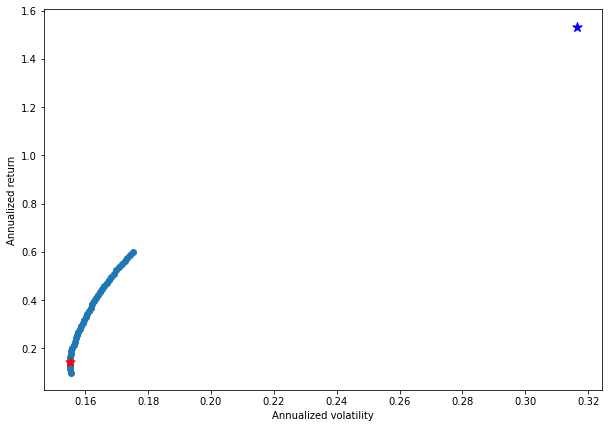

In [70]:
mvo(expected_returns, cov_matrix)

This variation of the MVO portfolio adds a maximum concentration variable to constrain the weight allocation.

One reason you to consider constraining the maximum weight of a stock is to force the portfolio to diversify its holdings. Otherwise, a portfolio can end up with concentrated exposure to a few select stocks. For example, the portfolio above has 27 positions, meaning the average weight is 3.7% but the portfolio is highly concentrated in VIRT at 15.62%, VRS at 22.32%, DNB at 13.84%. Those 3 stocks by themselves account for more than half the portfolio weight

In [101]:
def constrainedMVO(expected_returns, cov_matrix, target_return, max_concentration):
    '''
    Construction of the efficient frontier by applying a linear combination of the Max Sharpe and Min Var portfolios
    This function does not allow short-selling in its estimation.
    
    no position can exceed the max_concentration
    
    '''
    
    size_portfolio = expected_returns.count()
    constraints = ({'type':'eq','fun': lambda x:portfolio_return(x, expected_returns, cov_matrix)-target_return},
                   {'type':'eq', 'fun': lambda x:np.sum(x)-1},
                   {'type':'ineq', 'fun':  lambda x:max_concentration-x})
    bounds = tuple((0, 1) for x in range(size_portfolio))
    scale = size_portfolio * [1./size_portfolio] # initialize at equal weights
    args = (expected_returns, cov_matrix) #args to be passed to optimising function
    results = sco.minimize(portfolio_vol, scale, args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    
    portfolio_weights = results["x"].round(2)
    return pd.DataFrame(portfolio_weights, index=expected_returns.index, columns=["Weights"])
    
def surfaceMVO(expected_returns, cov_matrix, max_target, max_concentration):
    '''
    generate an efficient surface over a range of target returns constrained by an upper limit on any single stock position
    '''
    
    # Vary the target return
    target_range = np.linspace(0,max_target,50)
    concentration_range = np.linspace(max_concentration, 1, 50)
    
    graph = []
    for target in target_range:
        for concentration in concentration_range:
            graph.append(constrainedMVO(expected_returns, cov_matrix, target, concentration))
    
    return graph
   

    
        

In [102]:
graph = surfaceMVO(expected_returns, cov_matrix, 0.3, 0.15)

2500

In [105]:
from mpl_toolkits.mplot3d import Axes3D 